# Лабораторная работа №4: Методы снижения размерности. Регуляризация логистической регрессии.

**Номер варианта: 12**

**Данные: winequality-white_for_lab**

**Зависимая переменная: Y**

**Объясняющие переменные: все, кроме quality и Y**

**Метод снижения размерности: PLS**

**Метод регуляризации: лассо-регрессия**

**Задание :**
1. Данные своего варианта (см. таблицу ниже) разделить на выборку для построения
моделей (85%) и отложенные наблюдения (15%). Оставить в таблице только указанные в
варианте переменные. Отложенные наблюдения использовать только для прогноза по
лучшей модели.
2. Провести предварительный и корреляционный анализ данных с помощью статистик и
графиков из этой лабораторной.
3. Снизить размерность пространства объясняющих переменных методом, указанным в
варианте. Обосновать количество главных компонент. Построить модель логистической
регрессии на преобразованном пространстве объясняющих переменных. Оценить
точность модели методом перекрёстной проверки.
4. Провести регуляризацию модели логистической регрессии методом, указанным в
варианте. Подобрать оптимальное значение гиперпараметра методом перекрёстной
проверки. Построить график сжатия параметров модели.
5. Выбрать наиболее точную модель из полученных в пунктах 3 и 4, сделать по ней прогноз на отложенные наблюдения, оценить точность этого прогноза.

---



# Загрузка модулей, констант, данных

**Загрузка модулей**

In [1]:
# загрузка пакетов: инструменты --------------------------------------------
# работа с массивами
import numpy as np
# фреймы данных
import pandas as pd
# распределение Стьюдента для проверки значимости
from scipy.stats import t
# подсчёт частот внутри массива
from collections import Counter
# графики
import matplotlib as mpl
from matplotlib import pyplot as plt
# стили и шаблоны графиков на основе matplotlib
import seaborn as sns

# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets

# загрузка пакетов: модели -------------------------------------------------
# стандартизация показателей
from sklearn.preprocessing import StandardScaler
# метод главных компонент
from sklearn.decomposition import PCA
# метод частных наименьших квадратов
from sklearn.cross_decomposition import PLSRegression
# логистическая регрессия (ММП)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
# перекрёстная проверка по k блокам
from sklearn.model_selection import KFold, cross_val_score
# расчёт Acc и сводка по точности классификации
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# функция, которая строит график сжатия коэффициентов в ридж и лассо
# из репозитория к книге С.Рашки Python и машинное обучение,
# слегка переработанная
def plot_coeffs_traces (X, y, class_number, penalty_name, C_opt, col_names,
C_min_pow=-4, C_max_pow=3.):
    fig = plt.figure()
    ax = plt.subplot(111)

    # палитра
    colors = sns.color_palette("Spectral", len(col_names)-1)

    weights, params = [], []
    for c in np.arange(C_min_pow, C_max_pow+1):
        lr = LogisticRegression(penalty=penalty_name,
            C=10.**c, solver='liblinear',
            multi_class='ovr', random_state=SEED)
        lr.fit(X, y)
        weights.append(lr.coef_[class_number])
        params.append(10**c)
    weights = np.array(weights)
    for column, color in zip(range(weights.shape[1]), colors):
        plt.plot(params, weights[:, column],
            label=col_names[column],
            color=color)
    # отсечки по оптимальным C
    plt.axvline(x=C_opt[class_number], color='magenta',
    linestyle='--', linewidth=1)
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlim([10**(C_min_pow), 10**C_max_pow])
    plt.ylabel('weight coefficient')
    plt.xlabel('C')
    plt.xscale('log')
    plt.legend(loc='upper left')
    ax.legend(loc='upper center',
        bbox_to_anchor=(1.38, 1.03),
        ncol=1, fancybox=True)
    plt.show()


**Константы**

In [3]:
SEED = 12
TRAIN_RATIO = 0.85
sns.set_style("whitegrid")
sns.set_palette("deep")

**Загрузка данных**

In [4]:
fileURL = "https://raw.githubusercontent.com/aksyuk/MTML/main/Labs/data/winequality-white_for_lab.csv"
df_all = pd.read_csv(fileURL)
df_all = df_all.drop("quality", axis=1)

In [5]:
df_all.isna().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
Y                       0
dtype: int64

**Разделение данных на тренировочную и тестовую выборки**

In [6]:
df_train = df_all.sample(frac=TRAIN_RATIO, random_state=SEED)
df_test = df_all.drop(df_train.index)

# Предварительный анализ данных

**Описательные статистики**

Считаем доли классов целевой переменной Y

In [7]:
df_train["Y"].unique()

array([1, 0])

Доли классов в тренировочной выборке

In [8]:
np.around(df_train["Y"].value_counts() / len(df_train.index), 3)

1    0.663
0    0.337
Name: Y, dtype: float64

Рассчитаем описательные статистики для объясняющих переменных

In [9]:
df_train.iloc[:, :6].describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide
count,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000
mean,6.856318,0.277989,0.335719,6.438218,0.046030,35.388662
std,0.840313,0.101073,0.122165,5.035408,0.022404,17.017232
min,3.800000,0.080000,0.000000,0.600000,0.012000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000
50%,6.800000,0.260000,0.320000,5.300000,0.043000,34.000000
75%,7.300000,0.320000,0.390000,10.000000,0.050000,46.000000
max,14.200000,1.100000,1.660000,31.600000,0.346000,289.000000


In [10]:
df_train.iloc[:, 6:11].describe()

,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000
mean,138.513572,0.994055,3.187881,0.489683,10.500002
std,42.575390,0.002936,0.150310,0.113528,1.232046
min,18.000000,0.987110,2.720000,0.220000,8.000000
25%,108.000000,0.991730,3.090000,0.410000,9.400000
50%,134.000000,0.993800,3.180000,0.480000,10.400000
75%,168.000000,0.996200,3.280000,0.550000,11.400000
max,440.000000,1.010300,3.810000,1.080000,14.200000


Выводы по описательным статистикам: значения объясняющих переменных положительные,
масштабы измерения отличаются. Для работы с методами снижения размерности и
регуляризации понадобится стандартизация значений.

**Визуализация разброса переменных внутри классов**

Поскольку в наборе данных 11 объясняющих переменных, и все они непрерывные, анализ
матричного графика разброса будет затруднительным. Построим коробчатые диаграммы дляобъясняющих переменных, чтобы сравнить средние уровни и разброс по классам.

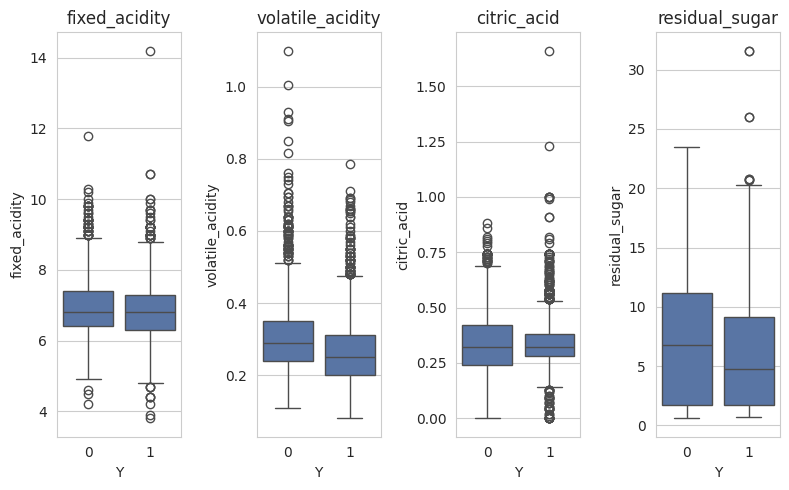

In [11]:
fig = plt.figure(figsize=(8, 5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
axs = [ax1, ax2, ax3, ax4]
cols_loop = list(df_train.columns[:4].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=df_train, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

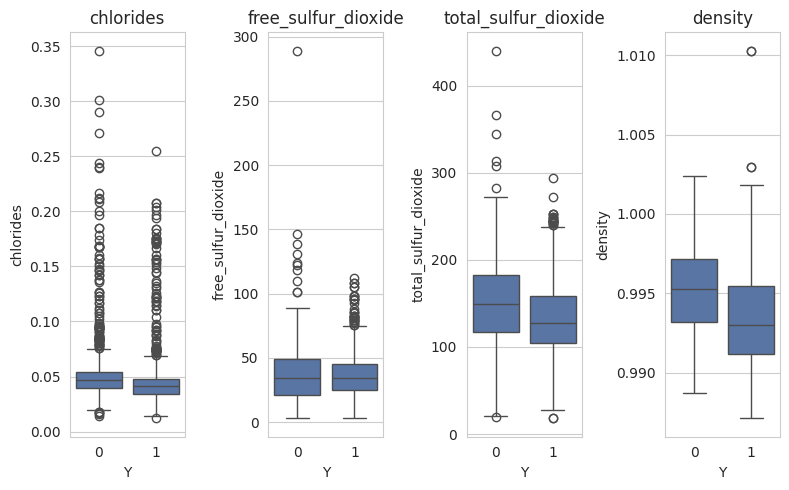

In [12]:
fig = plt.figure(figsize=(8, 5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
axs = [ax1, ax2, ax3, ax4]
cols_loop = list(df_train.columns[4:8].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=df_train, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

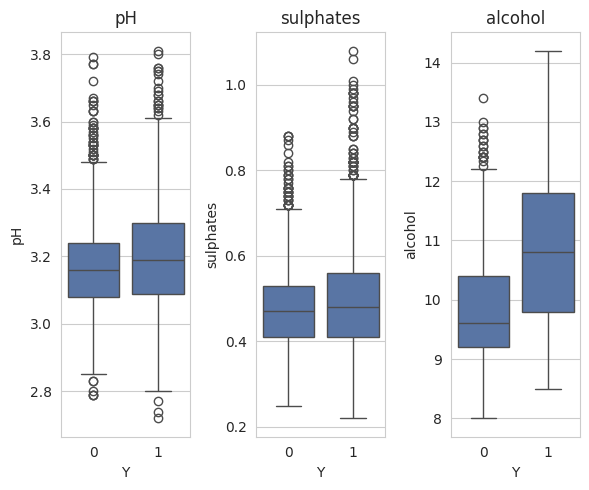

In [13]:
fig = plt.figure(figsize=(6, 5))
gs = mpl.gridspec.GridSpec(1, 3)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
axs = [ax1, ax2, ax3, ax4]
cols_loop = list(df_train.columns[8:11].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=df_train, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

На графиках отличие в медианах и разбросе между классами прослеживается практически по большинству объясняющих переменных. Меньше всего различаются коробчатые диаграммы по
переменной `fixed_acidity` . Это говорит о том, классы по зависимой переменной `Y` неплохо разделяются по объясняющим переменным.

# Корреляционный анализ

Теперь посмотрим на взаимодействие объясняющих переменных.

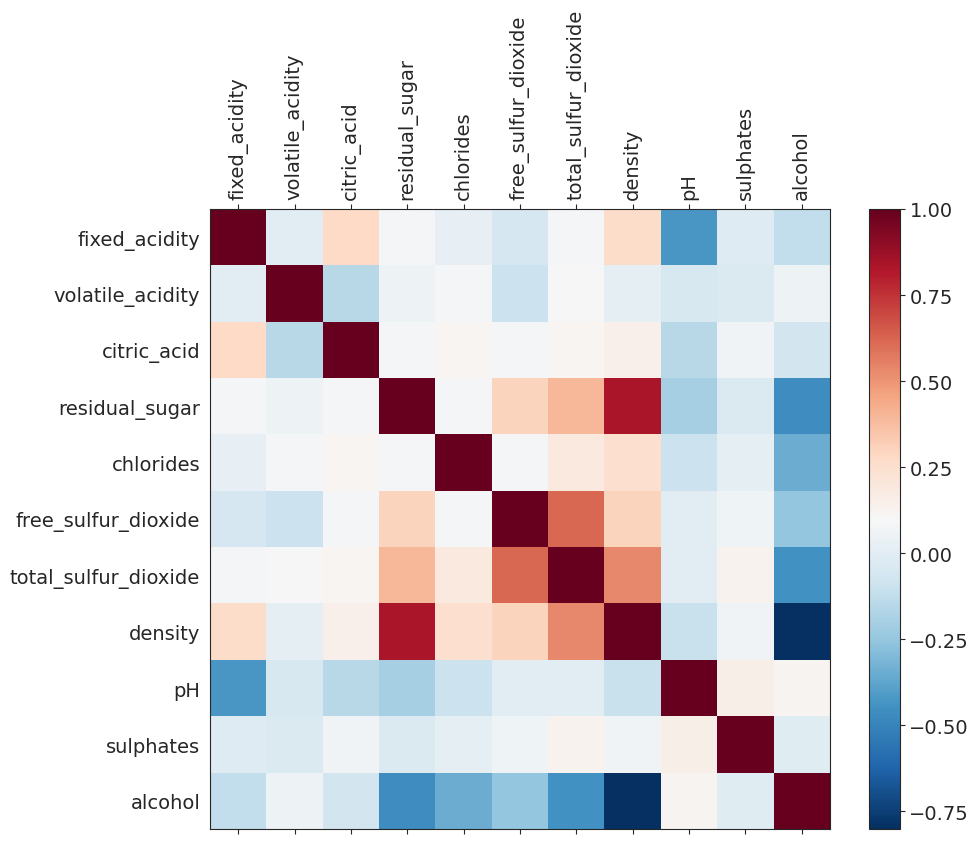

In [14]:
corr_mat = df_train.drop("Y", axis=1).corr()
col_names = df_train.drop("Y", axis=1).columns

sns.set_style("white")
f = plt.figure(figsize=(10, 8))
plt.matshow(corr_mat, fignum=f.number, cmap='RdBu_r')
# координаты для названий строк и столбцов
tics_coords = np.arange(0, len(col_names))
# рисуем подписи
plt.xticks(tics_coords, col_names, fontsize=14, rotation=90)
plt.yticks(tics_coords, col_names, fontsize=14)
# настраиваем легенду справа от тепловой карты
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(labelsize=14)
plt.show()

Между объясняющими переменными обнаруживаются как прямые, так и обратные линейные
взаимосвязи. Выведем все значимые коэффициенты в одной таблице и определим
минимальный / максимальный из них.

In [15]:
df = corr_mat
df = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
df = df.stack().reset_index()
df.columns = ["Показатель 1", "Показатель 2", "Корреляция"]
t_stat = np.sqrt((len(df_train.index) - 2) / (1 - df[("Корреляция")].values ** 2))
df["P-значение"] = 2 * (1 - t.cdf(abs(t_stat), len(df_train.index) - 2))
df.loc[df["P-значение"] < 0.05].sort_values("Корреляция")

,Показатель 1,Показатель 2,Корреляция,P-значение
51,density,alcohol,-0.801681,0.0
33,residual_sugar,alcohol,-0.462378,0.0
48,total_sulfur_dioxide,alcohol,-0.447634,0.0
7,fixed_acidity,pH,-0.423944,0.0
39,chlorides,alcohol,-0.350835,0.0
44,free_sulfur_dioxide,alcohol,-0.247488,0.0
31,residual_sugar,pH,-0.198513,0.0
24,citric_acid,pH,-0.154123,0.0
10,volatile_acidity,citric_acid,-0.148407,0.0
9,fixed_acidity,alcohol,-0.119608,0.0


# Методы сокращения размерности. Метод частных наименьших квадратов

Метод на всех наблюдениях тренировочной выборки

In [16]:
sc = StandardScaler()
X_train_std = sc.fit_transform(df_train.iloc[:, :11].values)

# функция для оценки модели, берём все компоненты, по числу столбцов X
pls = PLSRegression(n_components=11)
# значения зависимой переменной превращаем в фиктивные по классам
Y_train = pd.get_dummies(df_train[['Y']].astype(str))
# оцениваем
pls.fit(X_train_std, Y_train)
# считаем долю объяснённой дисперсии
frac_var_expl = np.var(pls.x_scores_, axis = 0) / np.sum(np.var(X_train_std, axis=0))
print('Доли объяснённой дисперсии по компонентам в PLS:\n',
np.around(frac_var_expl, 3),
'\nОбщая сумма долей:', np.around(sum(frac_var_expl), 3))

Доли объяснённой дисперсии по компонентам в PLS:
 [0.223 0.105 0.057 0.09  0.063 0.035 0.01  0.013 0.071 0.072 0.085] 
Общая сумма долей: 0.824


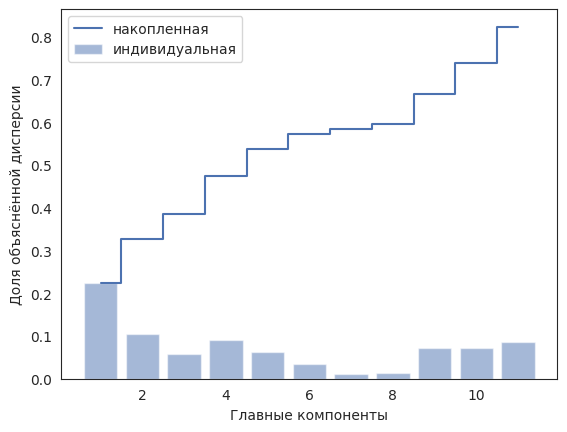

In [17]:
# график объяснённой дисперсии
plt.bar(range(1, 12), frac_var_expl, alpha=0.5,
align='center', label='индивидуальная')
plt.step(range(1, 12), np.cumsum(frac_var_expl),
where='mid', label='накопленная')
plt.ylabel('Доля объяснённой дисперсии')
plt.xlabel('Главные компоненты')
plt.legend()
plt.show()

Метод на двух компонентах на наблюдениях тренировочной выборки


In [18]:
# сокращаем пространство компонент до 2
pls = PLSRegression(n_components=2)
# перестраиваем модель
pls.fit(X_train_std, Y_train)
# пересчитываем X
X_train_pls = pls.transform(X_train_std)
# предсказываем принадлежности классов для обучающего набора
Y_train_pred = pls.predict(X_train_std)
pd.DataFrame(Y_train_pred)

,0,1
0,0.163835,0.836165
1,0.423365,0.576635
2,0.194434,0.805566
3,0.208655,0.791345
4,0.554697,0.445303
...,...,...
4158,0.267817,0.732183
4159,0.567793,0.432207
4160,0.351040,0.648960
4161,0.363295,0.636705


In [19]:
# вычисляем классы
Y_train_hat = list()
for y_i in Y_train_pred :
    Y_train_hat.append([i for i in range(len(y_i)) if y_i[i] == max(y_i)][0])
# сколько наблюдений попали в каждый класс по модели
Counter(Y_train_hat).items()

dict_items([(1, 3277), (0, 886)])

Изобразим классы на графике в координатах 2 главных компонент по PLS

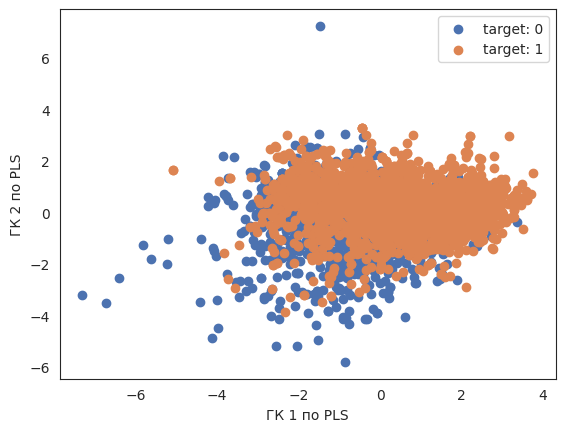

In [20]:
plt.scatter(X_train_pls[df_train['Y'] == 0][:, 0],
    X_train_pls[df_train['Y'] == 0][:, 1], label='target: 0')
plt.scatter(X_train_pls[df_train['Y'] == 1][:, 0],
    X_train_pls[df_train['Y'] == 1][:, 1], label='target: 1')
plt.xlabel('ГК 1 по PLS')
plt.ylabel('ГК 2 по PLS')
plt.legend()
plt.show()

Судя по графику, классы плохо разделяются в пространстве двух главных компонент.
Построим логистическую регрессию и оценим её точность с помощью перекрёстной
проверки.

In [21]:
score = []
score_models = []
# функция разбиения на блоки для перекрёстной проверки
# для чистоты эксперимента возьмём другое ядро генератора случайных чисел
kf_10 = KFold(n_splits=10, random_state=SEED+1, shuffle=True)
# считаем точность модели (Acc) с перекрёстной проверкой по блокам
# функция cross_val_score не сработает, т.к. у нас мультиклассовая
# классификация, поэтому делаем вручную
# значения Y как метки классов
Y_train = df_train.Y.values
# значения Y как фиктивные переменные
Y_train_dummy = pd.get_dummies(Y_train.astype(str))
# модель внутри блока
pls_cv = PLSRegression(n_components=2)
# для записи Acc по блокам
acc_blocks = list()
# цикл по блокам
for train_index, test_index in kf_10.split(X_train_std, df_train.Y.values):
    # данные для модели внутри блока
    X_i_train = X_train_std[train_index]
    Y_i_train = Y_train_dummy.iloc[train_index, :]
    # данные для прогноза вне блока
    X_i_test = X_train_std[test_index]
    Y_i_test = Y_train[test_index]
    # оцениваем модель на блоке
    pls_cv.fit(X_i_train, Y_i_train)
    # делаем прогноз y вне блока
    Y_pred = pls.predict(X_i_test)
    Y_hat = list()
    for y_i in Y_pred :
        Y_hat.append([i for i in range(len(y_i)) if y_i[i] == max(y_i)][0])
    # считаем точность
    acc = accuracy_score(Y_i_test, Y_hat)
    acc_blocks.append(acc)
score.append(np.around(np.mean(acc_blocks), 3))
score_models.append('logit_PLS')
print('Модель ', score_models[0], ', перекрёстная проверка по 10 блокам',
'\nAcc = ', np.around(score[0], 2), sep='')

Модель logit_PLS, перекрёстная проверка по 10 блокам
Acc = 0.74


# Методы сжатия. Лассо-регрессия

Функция LogisticRegression() умеет работать с мультиклассовой классификацией,
используя при оценке параметров подход один класс против остальных. Построим лассо на
наших данных.

In [22]:
# функция для построения модели
logit_lasso = LogisticRegression(penalty='l1', solver='liblinear')
# оцениваем параметры
logit_lasso.fit(X_train_std, Y_train)
# выводим параметры
print('Константы моделей для классов:\n', np.around(logit_lasso.intercept_, 3),
'\nКоэффициенты моделей для классов:\n', np.around(logit_lasso.coef_, 3))

Константы моделей для классов:
 [0.901] 
Коэффициенты моделей для классов:
 [[ 0.101 -0.651  0.     0.976  0.025  0.153 -0.054 -1.062  0.197  0.211
   0.74 ]]


Подбираем гиперпараметр регуляризации с помощью перекрёстной проверки. В функции
LogisticRegression() есть аргумент ***C*** – это инверсия гиперпараметра λ.

In [23]:
# поиск оптимального значения C:
# подбираем C по наибольшей точности с перекрёстной проверкой
lasso_cv = LogisticRegressionCV(cv=10, random_state=SEED+3,
penalty='l1', solver='liblinear')
lasso_cv.fit(X_train_std, Y_train)
# значения параметра C (инверсия лямбды), которые дают наилучшую
# точность для каждого класса
lasso_cv.C_

array([0.04641589])

In [24]:
1 / lasso_cv.C_

array([21.5443469])

Гиперпараметр λ = 21.54.

Найдем точность полученной модели.

In [25]:
score.append(np.around(lasso_cv.score(X_train_std, Y_train), 3))
score_models.append('logit_lasso')
print('Модель ', score_models[0], ', перекрёстная проверка по 10 блокам',
'\nAcc = ', score[0], sep='')

Модель logit_PLS, перекрёстная проверка по 10 блокам
Acc = 0.735


Изобразим изменение коэффициентов ридж-регрессии на графике и сделаем отсечку на уровне оптимального параметра .

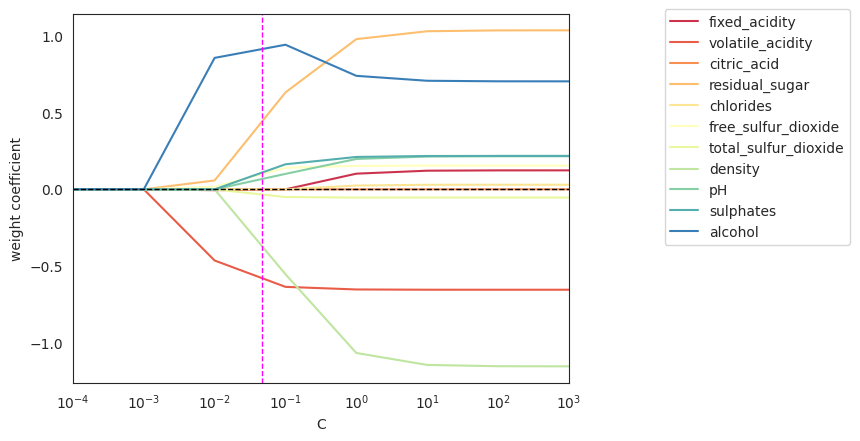

In [26]:
plot_coeffs_traces(X_train_std, Y_train, 0, 'l1', lasso_cv.C_, df_train.columns)

# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точность построенных моделей.

In [27]:
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,logit_PLS,0.735
1,logit_lasso,0.752


Самой точной оказывается лассо-регрессия. Сделаем прогноз на отложенные наблюдения.

In [28]:
# формируем объекты с данными отложенной выборки
X_pred_std = sc.fit_transform(df_test.iloc[:, :11].values)
Y_pred = df_test.Y
Y_hat = logit_lasso.predict(X_pred_std)
# отчёт по точности на отложенных наблюдениях
print(classification_report(Y_pred, Y_hat))

              precision    recall  f1-score   support

           0       0.67      0.49      0.56       237
           1       0.78      0.89      0.83       498

    accuracy                           0.76       735
   macro avg       0.73      0.69      0.70       735
weighted avg       0.75      0.76      0.75       735



Итак, методом логистической регрессии со сжатием коэффициентов с L1-регуляризацией мы получили модель классификации двух видов красных вин с точностью 76%.